<a href="https://colab.research.google.com/github/shubhamksingh1/TextClassification/blob/main/German/BertTextClassification_German_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Overview

We are going to use [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers) - an NLP library based on the [Transformers](https://github.com/huggingface/transformers) library by HuggingFace. Simple Transformers allows us to fine-tune Transformer models in a few lines of code.  

As the dataset, we are going to use the [Germeval 2019](https://projects.fzai.h-da.de/iggsa/projekt/), which consists of German tweets. We are going to detect and classify abusive language tweets. These tweets are categorized in 4 classes: `PROFANITY`, `INSULT`, `ABUSE`, and `OTHERS`.

### We are going to

- install Simple Transformers library
- select a pre-trained monolingual model
- load the dataset
- train/fine-tune our model
- evaluate the results of it
- save and load the model
- test the loaded model on a real example

# Install Simple Transformers library 

In [ ]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

simpletransformers==0.47.2


# Select a pre-trained monolingual model

As mentioned above the Simple Transformers library is based on the Transformers library from HuggingFace. This enables us to use every pre-trained model provided in the [Transformers library](https://huggingface.co/transformers/pretrained_models.html) and all community-uploaded models. For a list that includes community-uploaded models, refer to [https://huggingface.co/models](https://huggingface.co/models).

We are going to use the `distilbert-base-german-cased` model. [DistilBERT is a small, fast, cheaper version of BERT](https://huggingface.co/transformers/model_doc/distilbert.html). It has 40% less parameters than `bert-base-uncased` and runs 60% faster while preserving over 95% of Bert’s performance.

# Load the dataset

In [ ]:
!wget https://projects.fzai.h-da.de/iggsa/wp-content/uploads/2019/08/germeval2019GoldLabelsSubtask1_2.txt
!wget https://projects.fzai.h-da.de/iggsa/wp-content/uploads/2019/09/germeval2019.training_subtask1_2_korrigiert.txt

--2020-08-12 08:58:54--  https://projects.fzai.h-da.de/iggsa/wp-content/uploads/2019/08/germeval2019GoldLabelsSubtask1_2.txt
Resolving projects.fzai.h-da.de (projects.fzai.h-da.de)... 141.100.60.75, 2001:67c:2184:82a:21a:4aff:fe16:1e6
Connecting to projects.fzai.h-da.de (projects.fzai.h-da.de)|141.100.60.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 543975 (531K) [text/plain]
Saving to: ‘germeval2019GoldLabelsSubtask1_2.txt’

germeval2019GoldLab 100%[===================>] 531.23K   771KB/s    in 0.7s    

2020-08-12 08:58:56 (771 KB/s) - ‘germeval2019GoldLabelsSubtask1_2.txt’ saved [543975/543975]

--2020-08-12 08:58:57--  https://projects.fzai.h-da.de/iggsa/wp-content/uploads/2019/09/germeval2019.training_subtask1_2_korrigiert.txt
Resolving projects.fzai.h-da.de (projects.fzai.h-da.de)... 141.100.60.75, 2001:67c:2184:82a:21a:4aff:fe16:1e6
Connecting to projects.fzai.h-da.de (projects.fzai.h-da.de)|141.100.60.75|:443... connected.
HTTP request sent, await

class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

0.  : Insult
1.  : Abuse
2.  : Profanity
3.  : Other




In [ ]:
import pandas as pd

class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

df1 = pd.read_csv('germeval2019GoldLabelsSubtask1_2.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])
df2 = pd.read_csv('germeval2019.training_subtask1_2_korrigiert.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])

df = pd.concat([df1,df2])
df['task2'] = df['task2'].str.replace('\r', "")
df['pred_class'] = df.apply(lambda x:  class_list.index(x['task2']),axis=1)


df = df[['tweet','pred_class']]

print(df.shape)
df.head()

(7011, 2)


,tweet,pred_class
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,1
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",3
3,@welt Wie verwirrt muss man sein um sich zu we...,1
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,1


In [ ]:
df.tail()

,tweet,pred_class
3975,250 Menschen auf der Demonstration gegen das D...,3
3976,Erneut Massaker an Kurdische ZivilistInnen dur...,3
3977,Hunderte Refugees haben die Grenze zur spanisc...,3
3978,Heute ab 17:00 Uhr an der Alten Oper FFM: Kund...,3
3979,Uns gibt es jetzt auch auf #twitter. Folgt uns...,3


In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df.shape

(7011, 2)

In [ ]:
df.head()

,tweet,pred_class
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,1
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",3
3,@welt Wie verwirrt muss man sein um sich zu we...,1
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,1


In [ ]:
df.tail()

,tweet,pred_class
7006,250 Menschen auf der Demonstration gegen das D...,3
7007,Erneut Massaker an Kurdische ZivilistInnen dur...,3
7008,Hunderte Refugees haben die Grenze zur spanisc...,3
7009,Heute ab 17:00 Uhr an der Alten Oper FFM: Kund...,3
7010,Uns gibt es jetzt auch auf #twitter. Folgt uns...,3


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import *
from tabulate import tabulate

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def univariate_categorical(df,x):
       
    print('\nNumber of unique values => ' + str(len(df[x].unique())) + '\n\n')

    plt.figure(figsize=(10, 10))
    
    y = "count"
    plt.subplot(2, 1, 1)
    plt.xticks(rotation=90)

    sns.countplot(df[x])
    count_df = df[x].value_counts().rename(y).reset_index().rename(columns={"index":x})
    y = "percent(%)"
    percent_df = df[x].value_counts(normalize=True).rename(y).reset_index().rename(columns={"index":x})
    plt.subplot(2, 1, 2)
    sns.barplot(percent_df[x], percent_df[y], data=percent_df)
    plt.xticks(rotation=90)
    plt.show()
    print(tabulate(pd.merge(percent_df, count_df, how='inner'), headers='keys', tablefmt='fancy_grid'))



Number of unique values => 4




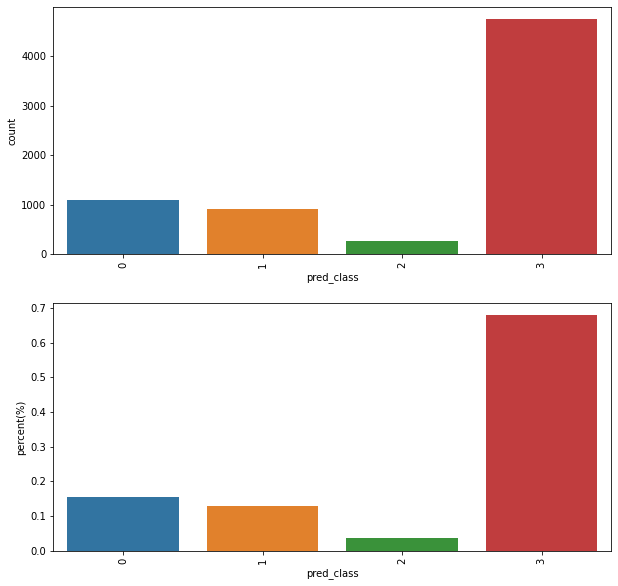

╒════╤══════════════╤══════════════╤═════════╕
│    │   pred_class │   percent(%) │   count │
╞════╪══════════════╪══════════════╪═════════╡
│  0 │            3 │    0.67879   │    4759 │
├────┼──────────────┼──────────────┼─────────┤
│  1 │            0 │    0.154472  │    1083 │
├────┼──────────────┼──────────────┼─────────┤
│  2 │            1 │    0.129226  │     906 │
├────┼──────────────┼──────────────┼─────────┤
│  3 │            2 │    0.0375125 │     263 │
╘════╧══════════════╧══════════════╧═════════╛


In [ ]:
univariate_categorical(df,'pred_class')

class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

0.  : Insult
1.  : Abuse
2.  : Profanity
3.  : Other




In [ ]:
df.head()

,tweet,pred_class
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,1
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",3
3,@welt Wie verwirrt muss man sein um sich zu we...,1
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,1


### Data Save

In [ ]:

df1 = pd.read_csv('germeval2019GoldLabelsSubtask1_2.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])
df2 = pd.read_csv('germeval2019.training_subtask1_2_korrigiert.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])

german_tweet = pd.concat([df1,df2])

In [ ]:
german_tweet.head()

,tweet,task1,task2
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT\r
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE\r
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER\r
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE\r
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE\r


In [ ]:

german_tweet['task2'] = german_tweet['task2'].str.replace('\r', "")

In [ ]:
german_tweet.head()

,tweet,task1,task2
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE


class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

0.  : Insult
1.  : Abuse
2.  : Profanity
3.  : Other




In [ ]:
german_tweet['pred_class'] = german_tweet.apply(lambda x:  class_list.index(x['task2']),axis=1)

In [ ]:
german_tweet.reset_index(drop=True,inplace=True)

In [ ]:
german_tweet.shape

(7011, 4)

In [ ]:
german_tweet.head()

,tweet,task1,task2,pred_class
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT,0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE,1
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER,3
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE,1
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE,1


In [ ]:
german_tweet.tail()

,tweet,task1,task2,pred_class
7006,250 Menschen auf der Demonstration gegen das D...,OTHER,OTHER,3
7007,Erneut Massaker an Kurdische ZivilistInnen dur...,OTHER,OTHER,3
7008,Hunderte Refugees haben die Grenze zur spanisc...,OTHER,OTHER,3
7009,Heute ab 17:00 Uhr an der Alten Oper FFM: Kund...,OTHER,OTHER,3
7010,Uns gibt es jetzt auch auf #twitter. Folgt uns...,OTHER,OTHER,3


In [ ]:
german_tweet.to_csv("/content/drive/My Drive/GermanTweetModel/German_Tweet.csv",index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.10,random_state=42)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (6309, 2)
test shape:  (702, 2)


# Load pre-trained model

In [ ]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-german-cased",
    num_labels=4,
    args=train_args
)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.lay

# Train model

In [ ]:
# Train the model
model.train_model(train_df)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:282: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:754: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


{'acc': 0.7051282051282052,
 'eval_loss': 0.8536044726656242,
 'f1': 0.7051282051282052,
 'mcc': 0.32757334708106417}

# save and load the model

save files without outputs/ 


In [ ]:
import os
import tarfile

def save_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')

In [ ]:
save_model('outputs','germeval-distilbert-german')

In [ ]:
!tar -zxvf ./germeval-distilbert-german.tar.gz

outputs/model_args.json
outputs/config.json
outputs/special_tokens_map.json
outputs/training_args.bin
outputs/tokenizer_config.json
outputs/pytorch_model.bin
outputs/eval_results.txt
outputs/vocab.txt


In [ ]:
!rm -rf outputs

In [ ]:
!cp -r "/content/germeval-distilbert-german.tar.gz" "/content/drive/My Drive/GermanTweetModel/"

# Test the loaded model on a real example

In [ ]:
import os
import tarfile

def unpack_model(model_name=''): 
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()


In [ ]:

unpack_model('/content/drive/My Drive/GermanTweetModel/germeval-distilbert-german')

In [ ]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "outputs/",
    num_labels=4,
    args=train_args
)

In [ ]:
class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

test_tweet = "Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])


OTHER


In [ ]:
class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

test_tweet = "Frau #Böttinger meine Meinung dazu ist sie sollten uns mit ihrem Pferdegebiss nicht weiter belästigen #WDR"

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])


OTHER


In [ ]:
class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

test_tweet = "@faznet @Gruene_Europa @SPDEuropa @CDU CDU steht seid Strauss, Kohl, Schäuble, vdLeyen für Korruption, Schwarzgeld, und dies überall..."

predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])


ABUSE


In [ ]:
"""
@AlanaBower @dailykos I didn't delete anything.Your psychotic delusions need to be treated.This isn't a metaphor.Find a psychiatrist.

"""
class_list = ['INSULT','ABUSE','PROFANITY','OTHER']

test_tweet = "@AlanaBower @dailykos Ich habe nichts gelöscht. Ihre psychotischen Wahnvorstellungen müssen behandelt werden. Dies ist keine Metapher. Finden Sie einen Psychiater."
predictions, raw_outputs = model.predict([test_tweet])

print(class_list[predictions[0]])



OTHER
